<a href="https://colab.research.google.com/github/Tam107/BDM/blob/test/Copy_of_TabTransformer_integrating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, LayerNormalization, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from IPython.display import Image
print("Completed")

Completed


Cell 2: Load and Preprocess Data

In [7]:
# Define columns to keep
cols_to_keep = ['price', 'brand', 'model', 'gearbox', 'kilometer', 'powerPS', 'yearOfRegistration', 'monthOfRegistration', 'dateCreated']

# Load data
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)

# Handle missing values
data['powerPS'] = data['powerPS'].replace(0, np.nan).fillna(data['powerPS'].median())
data['yearOfRegistration'] = data['yearOfRegistration'].replace(0, np.nan).fillna(data['yearOfRegistration'].median())
data['monthOfRegistration'] = data['monthOfRegistration'].replace(0, np.nan).fillna(data['monthOfRegistration'].median())
data['gearbox'] = data['gearbox'].fillna('manual')
data['model'] = data['model'].fillna('unknown')
data['brand'] = data['brand'].fillna('unknown')

# Extract year from dateCreated and calculate car_age
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data['car_age'] = data['adYear'] - data['yearOfRegistration']
data = data.drop(columns=['dateCreated', 'yearOfRegistration'])

# Ensure categorical columns are strings
data['brand'] = data['brand'].astype(str)
data['model'] = data['model'].astype(str)
data['gearbox'] = data['gearbox'].astype(str)

# Create dummy variables for gearbox
gearbox_dummies = pd.get_dummies(data['gearbox'])
data = pd.concat([data, gearbox_dummies], axis=1).drop('gearbox', axis=1)

# Add new features
data['power_per_km'] = data['powerPS'] / (data['kilometer'] + 1)  # Avoid division by zero
data['age_power_interaction'] = data['car_age'] * data['powerPS']

# Define numeric columns
numeric_cols = [col for col in data.columns if col not in ['price', 'brand', 'model']]

# Filter out price = 0
data = data[data['price'] > 0]
print(f"Number of rows after removing price=0: {len(data)}")

# Clip outliers
for col in ['price', 'kilometer', 'powerPS', 'car_age', 'power_per_km', 'age_power_interaction']:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    print(f"Clipping {col}: lower_bound={lower_bound}, upper_bound={upper_bound}")
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Normalize data
scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
price_scaler = MinMaxScaler()
data['price'] = price_scaler.fit_transform(data[['price']])
print("\nPrice Scaler Parameters:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

# Final data inspection
print("\n5 dòng đầu tiên sau khi xử lý outliers và chuẩn hóa:")
print(data.head())

Number of rows after removing price=0: 360750
Clipping price: lower_bound=110.0, upper_bound=36500.0
Clipping kilometer: lower_bound=5000.0, upper_bound=150000.0
Clipping powerPS: lower_bound=45.0, upper_bound=340.0
Clipping car_age: lower_bound=-2.0, upper_bound=37.0
Clipping power_per_km: lower_bound=0.0003279973760209918, upper_bound=0.020995800839832032
Clipping age_power_interaction: lower_bound=-170.0, upper_bound=5440.0

Price Scaler Parameters:
data_min_: [110.]
data_max_: [36500.]

5 dòng đầu tiên sau khi xử lý outliers và chuẩn hóa:
      price   powerPS    model  kilometer  monthOfRegistration       brand  \
0  0.010168  0.203390     golf   1.000000             0.454545  volkswagen   
1  0.499863  0.491525  unknown   0.827586             0.363636        audi   
2  0.266282  0.400000    grand   0.827586             0.636364        jeep   
3  0.038197  0.101695     golf   1.000000             0.454545  volkswagen   
4  0.095905  0.081356    fabia   0.586207             0.54545

Cell 3: Prepare Train, Validation, and Test Sets

In [8]:
# Features and target
X = data.drop(['price'], axis=1).copy()
y = data['price']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train into train and validation
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Prepare input lists
input_list_train_new = []
input_list_val = []
input_list_test = []

# Encode categorical variables
cat_encoders = {}
for col in ['brand', 'model']:
    unique_cat = np.unique(X_train_new[col])
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_cat)}
    input_list_train_new.append(X_train_new[col].map(cat_encoders[col]).values.astype(np.int32))
    input_list_val.append(X_val[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    input_list_test.append(X_test[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    print(f'\nCó {len(unique_cat)} giá trị duy nhất trong cột {col} trong tập huấn luyện.')

# Add numeric features
numeric_cols = [col for col in X_train_new.columns if col not in ['brand', 'model']]
input_list_train_new.append(X_train_new[numeric_cols].values.astype(np.float32))
input_list_val.append(X_val[numeric_cols].values.astype(np.float32))
input_list_test.append(X_test[numeric_cols].values.astype(np.float32))

# Convert target to float32 and check for NaN/inf
y_train_new = y_train_new.values.astype(np.float32)
y_val = y_val.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

# Check for NaN or inf in inputs and targets
for i, arr in enumerate(input_list_train_new):
    if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
        print(f"NaN or Inf detected in input_list_train_new[{i}]")
for i, arr in enumerate(input_list_val):
    if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
        print(f"NaN or Inf detected in input_list_val[{i}]")
for i, arr in enumerate(input_list_test):
    if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
        print(f"NaN or Inf detected in input_list_test[{i}]")
if np.any(np.isnan(y_train_new)) or np.any(np.isinf(y_train_new)):
    print("NaN or Inf detected in y_train_new")
if np.any(np.isnan(y_val)) or np.any(np.isinf(y_val)):
    print("NaN or Inf detected in y_val")
if np.any(np.isnan(y_test)) or np.any(np.isinf(y_test)):
    print("NaN or Inf detected in y_test")

# Replace NaN/inf with reasonable values if detected
for i in range(len(input_list_train_new)):
    input_list_train_new[i] = np.nan_to_num(input_list_train_new[i], nan=0.0, posinf=0.0, neginf=0.0)
for i in range(len(input_list_val)):
    input_list_val[i] = np.nan_to_num(input_list_val[i], nan=0.0, posinf=0.0, neginf=0.0)
for i in range(len(input_list_test)):
    input_list_test[i] = np.nan_to_num(input_list_test[i], nan=0.0, posinf=0.0, neginf=0.0)
y_train_new = np.nan_to_num(y_train_new, nan=0.0, posinf=0.0, neginf=0.0)
y_val = np.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

# Check data shapes
print(f'\nTập huấn luyện có {X_train_new.shape[0]} bản ghi và {X_train_new.shape[1]} cột.')
print(f'Tập validation có {len(X_val)} bản ghi.')
print(f'Tập kiểm tra có {len(X_test)} bản ghi.')


Có 40 giá trị duy nhất trong cột brand trong tập huấn luyện.

Có 250 giá trị duy nhất trong cột model trong tập huấn luyện.

Tập huấn luyện có 230880 bản ghi và 12 cột.
Tập validation có 57720 bản ghi.
Tập kiểm tra có 72150 bản ghi.


Cell 4: Define and Build TabTransformer Model

In [9]:
# Define Transformer block
def transformer_block(inputs, num_heads, ff_dim, dropout_rate=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    return out2

# Model parameters
n_unique_brand = len(np.unique(X_train_new['brand']))
n_unique_model = len(np.unique(X_train_new['model']))
brand_emb_dim = 8
model_emb_dim = 16
max_emb_dim = max(brand_emb_dim, model_emb_dim)

# Inputs
input_brand = Input(shape=(1,), name='input_brand')
input_model = Input(shape=(1,), name='input_model')
input_numeric = Input(shape=(len(numeric_cols),), name='input_numeric')

# Embeddings
emb_brand = Embedding(input_dim=n_unique_brand, output_dim=brand_emb_dim)(input_brand)
emb_model = Embedding(input_dim=n_unique_model, output_dim=model_emb_dim)(input_model)

# Reshape and align embeddings
emb_brand = Reshape(target_shape=(1, brand_emb_dim))(emb_brand)
emb_model = Reshape(target_shape=(1, model_emb_dim))(emb_model)
emb_brand = Dense(max_emb_dim)(emb_brand) if brand_emb_dim < max_emb_dim else emb_brand

# Combine into sequence for Transformer
cat_sequence = Concatenate(axis=1)([emb_brand, emb_model])

# Single Transformer block
transformer_output = transformer_block(cat_sequence, num_heads=4, ff_dim=64, dropout_rate=0.1)
transformer_output = Flatten()(transformer_output)

# Combine with numeric inputs
combined = Concatenate()([transformer_output, input_numeric])

# Simplified MLP
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(combined)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation='linear')(x)

# Create model
mlp_with_tabtransformer = Model(inputs=[input_brand, input_model, input_numeric], outputs=outputs, name='Refined_MLP_with_TabTransformer')

# Summary
print("\nTóm tắt mô hình Refined MLP with TabTransformer Support:")
mlp_with_tabtransformer.summary()


Tóm tắt mô hình Refined MLP with TabTransformer Support:


Model: "Refined_MLP_with_TabTransformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_brand (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 8)           │            320 │ input_brand[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_model (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 8)           │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 16)          │          4,000 │ input_model[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1, 16)          │            144 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 1, 16)          │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 2, 16)          │              0 │ dense_11[0][0],        │
│ (Concatenate)             │                        │                │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 2, 16)          │          4,304 │ concatenate_3[0][0],   │
│ (MultiHeadAttention)      │                        │                │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 2, 16)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 2, 16)          │              0 │ concatenate_3[0][0],   │
│                           │                        │                │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 2, 16)          │             32 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 2, 64)          │          1,088 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 2, 16)          │          1,040 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 2, 16)          │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 2, 16)          │              0 │ layer_normalization_4… │
│                           │                        │                │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 2, 16)          │             32 │ add_5[0][0]            │
│ (LayerNormalization) 

 Total params: 27,729 (108.32 KB)

 Trainable params: 27,281 (106.57 KB)

 Non-trainable params: 448 (1.75 KB)

Cell 5: Train the Model

Epoch 1/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - loss: 1.0591 - mae: 0.2461 - val_loss: 0.0325 - val_mae: 0.0933 - learning_rate: 0.0010
Epoch 2/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - loss: 0.0216 - mae: 0.0790 - val_loss: 0.0182 - val_mae: 0.0766 - learning_rate: 0.0010
Epoch 3/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0163 - mae: 0.0724 - val_loss: 0.0203 - val_mae: 0.0838 - learning_rate: 0.0010
Epoch 4/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 0.0143 - mae: 0.0657 - val_loss: 0.0241 - val_mae: 0.1039 - learning_rate: 0.0010
Epoch 5/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0123 - mae: 0.0613 - val_loss: 0.0323 - val_mae: 0.1046 - learning_rate: 0.0010
Epoch 6/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0120 - mae: 0.0598 - val_loss: 0.0125 - val_mae: 0.0653 - learning_rate: 0.0010
Epoch 7/200
902/902 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.0104 - mae: 0.0575 - val_loss: 0.0123 - val_mae: 0.0676 - learnin

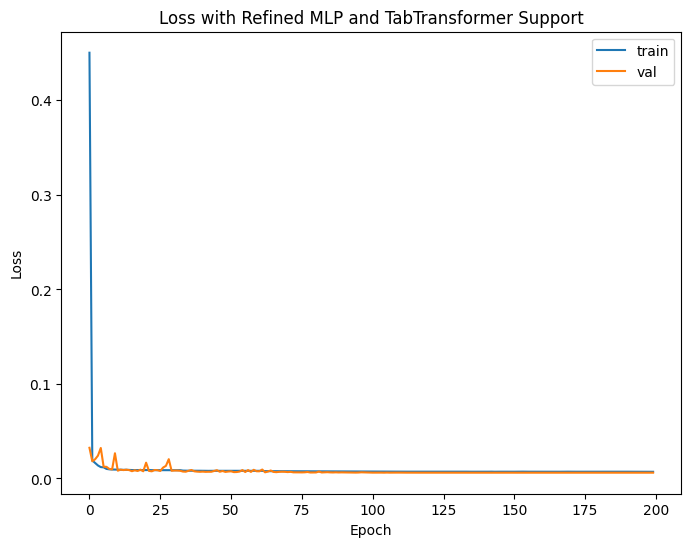

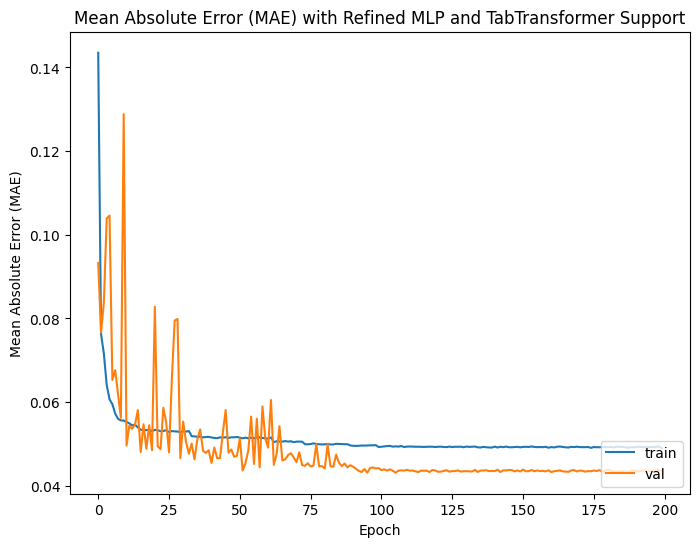

In [10]:
# Compile model with gradient clipping
mlp_with_tabtransformer.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
    metrics=['mae']
)

# Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)  # Increased patience
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Train model
history = mlp_with_tabtransformer.fit(
    input_list_train_new,
    y_train_new,
    validation_data=(input_list_val, y_val),
    epochs=200,
    batch_size=256,  # Reverted to smaller batch size for better updates
    verbose=1,
    callbacks=[es, lr_scheduler]
)

# Debugging: Check predictions after training
y_train_pred_sample = mlp_with_tabtransformer.predict(input_list_train_new[:5])
y_train_pred_sample_unscaled = price_scaler.inverse_transform(y_train_pred_sample).flatten()
y_train_actual_sample_unscaled = price_scaler.inverse_transform(y_train_new[:5].reshape(-1, 1)).flatten()
print("\nSample Training Predictions vs Actual (Unscaled):")
for i in range(5):
    print(f"Predicted: {y_train_pred_sample_unscaled[i]:.2f}, Actual: {y_train_actual_sample_unscaled[i]:.2f}")

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss with Refined MLP and TabTransformer Support')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot MAE
plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) with Refined MLP and TabTransformer Support')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Cell 6: Evaluate the Model

2255/2255 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step

Sample Test Predictions vs Actual (Unscaled):
Predicted: 9306.70, Actual: 8299.00
Predicted: 3372.44, Actual: 6499.00
Predicted: 14766.62, Actual: 12950.00
Predicted: 14801.46, Actual: 12999.00
Predicted: 1189.37, Actual: 999.00


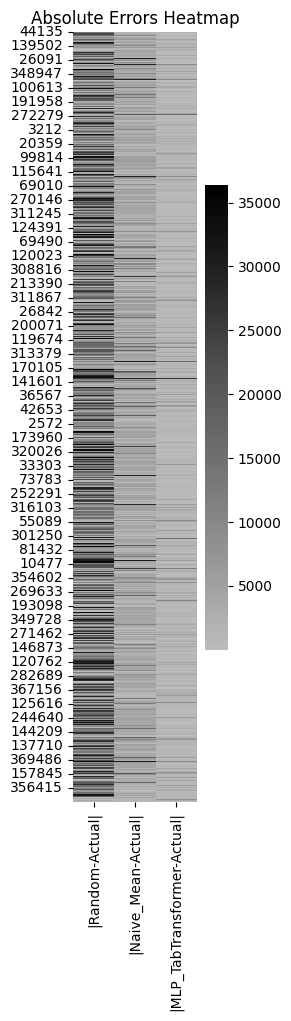

Evaluation Metrics:
            Random   Naive_Mean MLP_TabTransformer
ME   -12576.163842     28.46044          39.054813
RMSE  17759.792745  6834.731936        2751.107666
MAE   14731.306238  4830.548835        1561.737549
MAPE   1279.323021   352.496561          97.115051
R2       -5.752123    -0.000017           0.837976


In [11]:
# Generate predictions
y_test_predict = mlp_with_tabtransformer.predict(input_list_test)
y_test_predict_unscaled = price_scaler.inverse_transform(y_test_predict).flatten()
y_test_actual_unscaled = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Debugging: Print sample predictions and actual values
print("\nSample Test Predictions vs Actual (Unscaled):")
for i in range(5):
    print(f"Predicted: {y_test_predict_unscaled[i]:.2f}, Actual: {y_test_actual_unscaled[i]:.2f}")

# Create results DataFrame
result_df = pd.DataFrame(index=X_test.index, columns=['Random', 'Naive_Mean', 'MLP_TabTransformer', 'Actual'])
result_df['Actual'] = y_test_actual_unscaled
result_df['Naive_Mean'] = price_scaler.inverse_transform([[y_train.mean()]] * len(y_test)).flatten()
result_df['Random'] = np.random.uniform(price_scaler.data_min_[0], price_scaler.data_max_[0], len(y_test))
result_df['MLP_TabTransformer'] = y_test_predict_unscaled

# Calculate absolute errors
for m in ['Random', 'Naive_Mean', 'MLP_TabTransformer']:
    result_df[f'|{m}-Actual|'] = abs(result_df[m] - result_df['Actual'])

# Heatmap of absolute errors
table = result_df[['|Random-Actual|', '|Naive_Mean-Actual|', '|MLP_TabTransformer-Actual|']]
plt.figure(figsize=(2, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap')
plt.show()

# Evaluation metrics
metric_df = pd.DataFrame(index=['ME', 'RMSE', 'MAE', 'MAPE', 'R2'], columns=['Random', 'Naive_Mean', 'MLP_TabTransformer'])
n_test = len(result_df)

for m in metric_df.columns:
    metric_df.at['ME', m] = np.mean(result_df['Actual'] - result_df[m])
    metric_df.at['RMSE', m] = np.sqrt(np.mean((result_df['Actual'] - result_df[m])**2))
    metric_df.at['MAE', m] = np.mean(abs(result_df['Actual'] - result_df[m]))
    non_zero_mask = result_df['Actual'] != 0
    if non_zero_mask.sum() > 0:
        metric_df.at['MAPE', m] = np.mean(abs((result_df['Actual'][non_zero_mask] - result_df[m][non_zero_mask]) / result_df['Actual'][non_zero_mask])) * 100
    else:
        metric_df.at['MAPE', m] = np.nan
    ss_tot = np.sum((result_df['Actual'] - result_df['Actual'].mean())**2)
    ss_res = np.sum((result_df['Actual'] - result_df[m])**2)
    metric_df.at['R2', m] = 1 - (ss_res / ss_tot)

print("Evaluation Metrics:")
print(metric_df)

Cell 7: Answer Additional Questions

In [ ]:
# Question 1: Bias of Prediction Errors
prediction_errors = result_df['MLP_TabTransformer'] - result_df['Actual']
bias = prediction_errors.mean()

# Histogram of prediction errors
plt.figure(figsize=(10, 6))
plt.hist(prediction_errors, bins=50, color='blue', alpha=0.7)
plt.axvline(bias, color='red', linestyle='dashed', linewidth=2, label=f'Bias = {bias:.2f}')
plt.title('Histogram of Prediction Errors (Enhanced MLP with TabTransformer Support)')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Question 1: The bias of the prediction errors is {bias:.2f}")

# Question 2: Mean Percentage Profit Among Accepted Offers
y_val_predict = mlp_with_tabtransformer.predict(input_list_val)
y_val_predict = np.expm1(price_scaler.inverse_transform(y_val_predict).flatten())
y_val_actual = np.expm1(price_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten())

accepted_mask = y_val_predict > y_val_actual
accepted_actual = y_val_actual[accepted_mask]
accepted_predicted = y_val_predict[accepted_mask]

percentage_profit = ((accepted_predicted - accepted_actual) / accepted_actual) * 100
mean_percentage_profit = percentage_profit.mean() if len(percentage_profit) > 0 else 0

targeted_profit_margin = 10.0
profit_difference = mean_percentage_profit - targeted_profit_margin

print(f"\nQuestion 2:")
print(f"Mean percentage profit among accepted offers: {mean_percentage_profit:.2f}%")
print(f"Targeted profit margin (assumed): {targeted_profit_margin}%")
print(f"Difference from targeted profit margin: {profit_difference:.2f}%")
if abs(profit_difference) > 5:
    print("There is a significant difference compared to the targeted profit margin.")
else:
    print("The difference compared to the targeted profit margin is not substantial.")

Cell 8: Scatter Plots for Actual vs. Predicted Values

In [ ]:
# Function to create scatter plot
def scatter_plot(actual, predicted, title, color='blue'):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, color=color, alpha=0.5, label='Predicted')
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(title)
    plt.xlabel('Actual Price (€)')
    plt.ylabel('Predicted Price (€)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Generate predictions and inverse transform to original scale
y_train_pred = mlp_with_tabtransformer.predict(input_list_train_new)
y_train_pred = np.expm1(price_scaler.inverse_transform(y_train_pred).flatten())
y_train_actual = np.expm1(price_scaler.inverse_transform(y_train_new.reshape(-1, 1)).flatten())

y_val_pred = mlp_with_tabtransformer.predict(input_list_val)
y_val_pred = np.expm1(price_scaler.inverse_transform(y_val_pred).flatten())
y_val_actual = np.expm1(price_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten())

y_test_pred = mlp_with_tabtransformer.predict(input_list_test)
y_test_pred = np.expm1(price_scaler.inverse_transform(y_test_pred).flatten())
y_test_actual = np.expm1(price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten())

# Create scatter plots
scatter_plot(y_train_actual, y_train_pred, 'Training Set - Actual vs Predicted Prices', color='green')
scatter_plot(y_val_actual, y_val_pred, 'Validation Set - Actual vs Predicted Prices', color='orange')
scatter_plot(y_test_actual, y_test_pred, 'Test Set - Actual vs Predicted Prices', color='purple')